## 🚀 **mtslearn User demonstration**

## 1. Environmental preparation and Parameter settings

Please ensure your data is saved as a **CSV** or **Excel (.xls, .xlsx)** file. You may choose one of the two formats below.

#### 1. Wide Format

In the Wide Format, each row represents a single snapshot in time for a specific ID. Every measurement (like Heart Rate or Steps) has its own dedicated column.

**Required parameters:**

* **id_col**: Enter the unique identifier for the subject (e.g., `PATIENT_ID`). This groups all records belonging to the same person.
* **time_col**: Enter the timestamp or date (e.g., `RE_DATE`). This defines the sequence of the data.
* **label_col**: Enter the target result or category you want to predict (e.g., `outcome`).
* **Measurement Columns**: Any other columns (e.g., Heart Rate, Steps) are automatically treated as features.

**Table Example:**

| PATIENT_ID | RE_DATE | Heart Rate | Steps | outcome |
| :--- | :--- | :--- | :--- | :--- |
| U001 | 08:00 | 72 | 100 | 0 |
| U001 | 08:01 | 75 | 120 | 0 |
| U002 | 08:00 | 68 | 50 | 1 |

---

#### 2. Long Format

In the Long Format, each row represents a single measurement entry. 

**Required parameters:**

* **id_col**: The unique identifier for the subject (e.g., `PATIENT_ID`).
* **time_col**: The timestamp when the specific measurement was recorded (e.g., `RE_DATE`).
* **label_col**: The target result or category (e.g., `outcome`).
* **attr_col**: The name of the indicator or metric (e.g., `attribute`). This column tells the system *what* is being measured.
* **value_col**: The actual numerical value of that measurement (e.g., `value`).

**Table Example:**
| PATIENT_ID | RE_DATE | attribute | value | outcome |
| :--- | :--- | :--- | :--- | :--- |
| U001 | 08:00 | Heart Rate | 72 | 0 |
| U001 | 08:00 | Steps | 100 | 0 |
| U001 | 08:01 | Heart Rate | 75 | 0 |
| U002 | 08:00 | Heart Rate | 68 | 1 |

In [ ]:
from mtslearn import TSClassifier, TSProcessor, StaticProcessor, StaticClassifier

config = {
    "file_path":
    r'test_data\375_patients_example.xlsx',  # path to train data
    "data_type": 'wide',    # Define format: 'long' or 'wide'
    "num_type": 2,          # numbers of types

    "time_col": 'RE_DATE',  # Specify time column
    "id_col": 'PATIENT_ID', # Specify grouping column

    "label_col": 'outcome', # Specify label column
    "value_col": 'value',   # Long format only: value column
    "attr_col": 'attribute' # Long format only: attribute name column
}

## 2. Static data processing

In [ ]:
# Initialize the processor
static_processor = StaticProcessor()

# Read file
static_processor.read_file(**config)

# Feature extraction parameters
agg_params = {
    'agg_funcs': ['mean', 'std', 'max', 'min', 'median'], 
    'include_duration': True
}

# Data cleaning parameters
cleaning_params = {
    'fill_missing': 'mean', 
    'outlier_method': 'iqr'
}

# Extract static features
static_processor.extract_features(**agg_params)

# Static data cleaning
static_processor.data_cleaning(**cleaning_params)

# Export static feature table
static_processor.export('output/static_table.xlsx')


### 3. Static model training

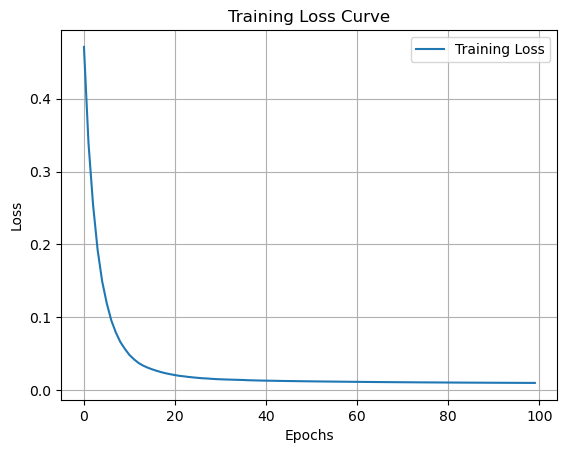


--- XGB Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        46
           1       0.91      1.00      0.95        29

    accuracy                           0.96        75
   macro avg       0.95      0.97      0.96        75
weighted avg       0.96      0.96      0.96        75



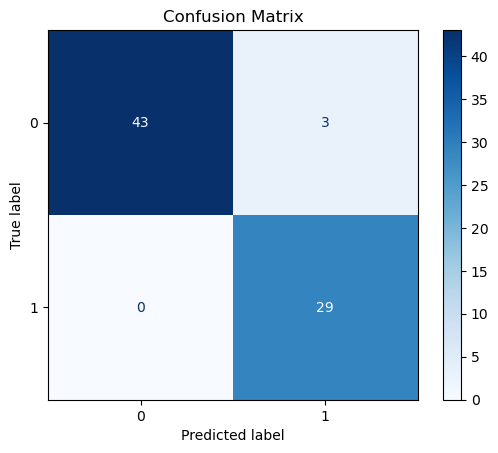

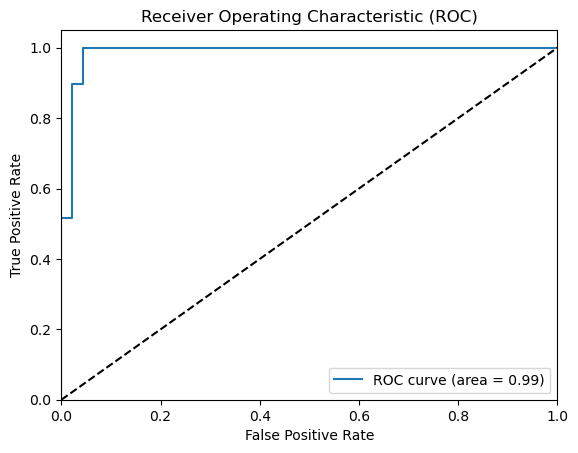

In [3]:
# Model config
model_params = {
    'model_type': 'XGB',
}

# Prepare data
X_train, X_test, y_train, y_test = static_processor.train_test_split(
    test_size=0.2, 
    shuffle=True, 
    random_state=42,
    standardize=True
)

# Train and evaluate
model = StaticClassifier(**model_params)
model.fit(X_train, y_train)
model.evaluate(X_test, y_test)

## 4. Time series data processing

In [ ]:
# Initialize
processor = TSProcessor()

# Read file
processor.read_file(**config)

# Data cleaning parameters
cleaning_params = {
    'fill_missing': 'mean',  # Method to fill NaNs ('mean', 'median', or 'ffill')
    'outlier_method': 'iqr'  # Strategy for outlier detection ('iqr', 'zscore', or 'clamp')
}

# Time resampling parameters
resample_params = {
    'freq': '1D',           # Resampling frequency (e.g., '1D', '2H')
    'fill_method': 'linear' # Interpolation method for newly created time steps (e.g., 'linear', 'time', 'nearest', 'ffill')
}

# Data cleaning
cleaned_df = processor.data_cleaning(**cleaning_params)

# Time resampling
processor.time_resample(**resample_params)  

# Export table
processor.export('output/TS_table.xlsx')

### 5. Time series model training

Training T-LSTM: 100%|██████████| 50/50 [00:01<00:00, 43.19it/s, loss=0.1581]



--- T-LSTM Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        46
           1       0.85      0.97      0.90        29

    accuracy                           0.92        75
   macro avg       0.91      0.93      0.92        75
weighted avg       0.93      0.92      0.92        75



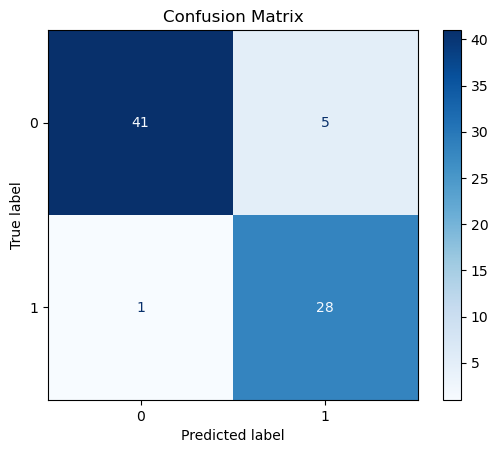

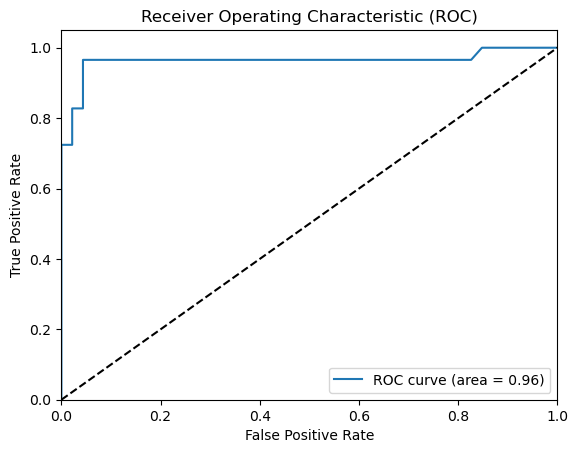

In [5]:
# Split the data and calculate the time_index
X_train, X_test, y_train, y_test = processor.train_test_split(
    test_size=0.2, 
    shuffle=True, 
    random_state=42,
    standardize=True
)

# model parameter
model_params = {
    'model_type': 'T-LSTM', # or 'LSTM'
    'hidden_size': 64,
    'time_index': processor.time_index  
}
# fit parameter
fit_params = {
    'epochs': 50,
    'lr': 0.005
}

# Initialization and Run
model = TSClassifier(**model_params)
model.fit(X_train, y_train, **fit_params)
model.evaluate(X_test, y_test)